In [1]:
%load_ext google.cloud.bigquery

In [7]:
import os
from google.cloud.bigquery.client import Client

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'C:\\Users\\Francesco\\service-account-file.json'
bq_client = Client()

In [41]:
%%bigquery RV --project charged-sector-315517

with
--contracts as (select distinct address from `bigquery-public-data.crypto_ethereum.contracts`),
double_entry_book as (
    -- debits
    select to_address as address, value as value, block_timestamp
    from `bigquery-public-data.crypto_ethereum.traces`
    where to_address is not null
    and status = 1
    and (call_type not in ('delegatecall', 'callcode', 'staticcall') or call_type is null)--and trace_type not in ('genesis', 'reward'))
    and DATE(block_timestamp) <= "2021-08-01"
    union all
    -- transaction fees credits
    select from_address as address, cast(receipt_gas_used as numeric) * cast(gas_price as numeric) as value, block_timestamp
    from `bigquery-public-data.crypto_ethereum.transactions`
    where DATE(block_timestamp) <= "2021-08-01"
)
,double_entry_book_by_date as (
    select 
        date(block_timestamp) as date, 
        t1.address, 
        sum(t1.value / 1e18 * case when t2.close is null then 3 else t2.close end) value_usd
    -- TODO: compute value in USD
    from double_entry_book t1
    left join `charged-sector-315517.eth.eth_usd_hist_min` t2 on DATETIME_TRUNC(t1.block_timestamp, MINUTE) = TIMESTAMP_SECONDS(t2.time)
    --left join contracts t3 on t1.address = t3.address
    --where t3.address is null
    group by date, t1.address
)
,daily_balances_with_gaps as (
    select 
        address, 
        date,
        sum(value_usd) over (partition by address order by date) as balance,
        lead(date, 1, "2021-08-01") over (partition by address order by date) as next_date
        from double_entry_book_by_date
)
,calendar as (
    select date from unnest(generate_date_array("2015-07-30", "2021-08-01")) as date
)
,daily_balances as (
    select address, calendar.date, balance
    from daily_balances_with_gaps
    join calendar on daily_balances_with_gaps.date <= calendar.date and calendar.date < daily_balances_with_gaps.next_date
)
select date, sum(balance) RV
from daily_balances
group by date
order by date

Downloading: 100%|██████████| 2194/2194 [00:02<00:00, 773.75rows/s] 


<AxesSubplot:>

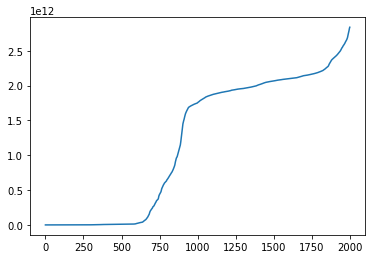

In [42]:
RV['RV'].plot()

In [43]:
%%bigquery supply --project charged-sector-315517

with ether_emitted_by_date  as (
  select date(block_timestamp) as date, sum(value) as value
  from `bigquery-public-data.crypto_ethereum.traces`
  where trace_type in ('genesis', 'reward')
  group by date(block_timestamp)
)
select date, sum(value) OVER (ORDER BY date) / 1e18 AS supply
from ether_emitted_by_date

Downloading: 100%|██████████| 2199/2199 [00:02<00:00, 866.80rows/s]


<AxesSubplot:>

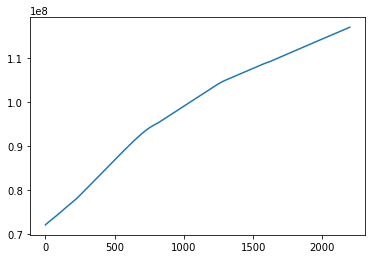

In [56]:
supply['supply'].astype('float').plot() #[supply['supply'].isnull()]#

In [19]:
%%bigquery close --project charged-sector-315517
select close from `charged-sector-315517.eth.eth_usd_hist_min` order by time

Downloading: 100%|██████████| 3148437/3148437 [00:11<00:00, 276900.13rows/s]


<AxesSubplot:>

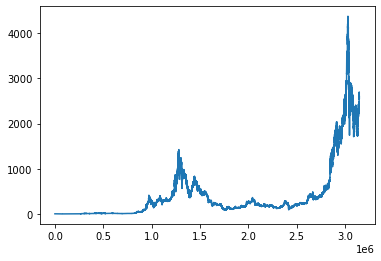

In [20]:
close['close'].plot()

In [76]:
%%bigquery price_daily --project charged-sector-315517

SELECT  date(TIMESTAMP_SECONDS(time)) date, close
FROM `charged-sector-315517.eth.eth_usd_hist_min`
where TIMESTAMP_SECONDS(time) = TIMESTAMP_TRUNC(TIMESTAMP_SECONDS(time), DAY)
order by date

Downloading: 100%|██████████| 2186/2186 [00:02<00:00, 884.45rows/s] 


<AxesSubplot:>

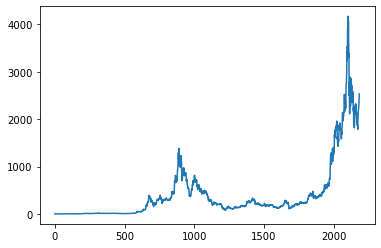

In [77]:
price_daily['close'].plot()

In [78]:
%%bigquery price_hourly --project charged-sector-315517

SELECT  TIMESTAMP_TRUNC(TIMESTAMP_SECONDS(time), HOUR) date, close
FROM `charged-sector-315517.eth.eth_usd_hist_min`
where TIMESTAMP_SECONDS(time) = TIMESTAMP_TRUNC(TIMESTAMP_SECONDS(time), HOUR)
order by date

Downloading: 100%|██████████| 52473/52473 [00:03<00:00, 15287.62rows/s]


<AxesSubplot:>

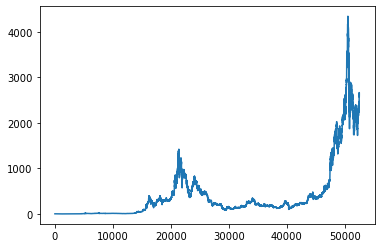

In [79]:
price_hourly['close'].plot()

In [66]:
%%bigquery eth_gini --project charged-sector-315517

with
price as (
    SELECT  date(TIMESTAMP_SECONDS(time)) date, close price
    FROM `charged-sector-315517.eth.eth_usd_hist_min`
    where TIMESTAMP_SECONDS(time) = TIMESTAMP_TRUNC(TIMESTAMP_SECONDS(time), DAY)
),
double_entry_book as (
    -- debits
    select to_address as address, value as value, block_timestamp
    from `bigquery-public-data.crypto_ethereum.traces`
    where to_address is not null
    and status = 1
    and call_type not in ('delegatecall', 'callcode', 'staticcall') --or call_type is null)
    and DATE(block_timestamp) <= "2021-08-01"
    union all
    -- credits
    select from_address as address, -value as value, block_timestamp
    from `bigquery-public-data.crypto_ethereum.traces`
    where from_address is not null
    and status = 1
    and call_type not in ('delegatecall', 'callcode', 'staticcall') --or call_type is null)
    and DATE(block_timestamp) <= "2021-08-01"
    union all
    -- transaction fees debits
    select miner as address, sum(cast(receipt_gas_used as numeric) * cast(gas_price as numeric)) as value, block_timestamp
    from `bigquery-public-data.crypto_ethereum.transactions` as transactions
    join `bigquery-public-data.crypto_ethereum.blocks` as blocks on blocks.number = transactions.block_number
    where DATE(transactions.block_timestamp) <= "2021-08-01"
    group by blocks.miner, block_timestamp
    union all
    -- transaction fees credits
    select from_address as address, -(cast(receipt_gas_used as numeric) * cast(gas_price as numeric)) as value, block_timestamp
    from `bigquery-public-data.crypto_ethereum.transactions`
    where DATE(block_timestamp) <= "2021-08-01"
)
,double_entry_book_by_date as (
    select 
        date(block_timestamp) as date, 
        address, 
        sum(value) as value
    from double_entry_book
    group by date, address
)
,daily_balances_with_gaps as (
    select 
        address, 
        date,
        sum(value) over (partition by address order by date) as balance,
        lead(date, 1, "2021-08-01") over (partition by address order by date) as next_date
        from double_entry_book_by_date
)
,calendar as (
    select date from unnest(generate_date_array("2015-07-30", "2021-08-01")) as date
)
,daily_balances as (
    select address, calendar.date, balance / 1e18 * price as balance
    from daily_balances_with_gaps
    join price on daily_balances_with_gaps.date = price.date
    join calendar on daily_balances_with_gaps.date <= calendar.date and calendar.date < daily_balances_with_gaps.next_date
)
,supply as (
    select
        date,
        sum(balance) as daily_supply
    from daily_balances
    group by date
)
,ranked_daily_balances as (
    select 
        daily_balances.date,
        balance,
        row_number() over (partition by daily_balances.date order by balance desc) as rank
    from daily_balances
    join supply on daily_balances.date = supply.date
    where safe_divide(balance, daily_supply) >= 0.0001
    ORDER BY safe_divide(balance, daily_supply) DESC
)

select 
    date, 
    -- (1 − 2B) https://en.wikipedia.org/wiki/Gini_coefficient
    1 - 2 * sum((balance * (rank - 1) + balance / 2)) / count(*) / sum(balance) as gini
from ranked_daily_balances
group by date
order by date asc

Downloading: 100%|██████████| 2185/2185 [00:03<00:00, 641.80rows/s]


<AxesSubplot:>

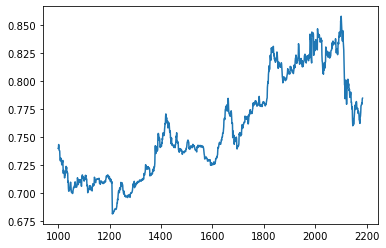

In [71]:
eth_gini['gini'][1000:].plot()

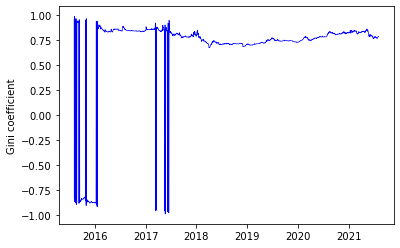

In [67]:
import matplotlib.pyplot as plt

plt.plot(eth_gini['date'], eth_gini['gini'], 'b-', label = "", linewidth = .7)
plt.ylabel('Gini coefficient')
plt.show()